In [113]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)



In [114]:
data = pd.read_csv('./data/dan_table.csv')

# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 

In [115]:
data = data[(data['RecordLoc'] == 1) ]

# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)

data2 = data[(data['RecordLoc'] == 2) ]

In [116]:
# pull out trial by trial info 

data_t = []

for mouse_id in np.unique(data['MouseID']):
    data_small = data[data['MouseID'] == mouse_id]

    trial_starts = np.where(data_small['TrialStart'] == 1)[0]

    
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):

        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        data_trial = data_small[t:trial_end];
        
        # get gcamp after nose poke enter and before lever press 
        npe_i = np.where(data_trial['NosePokeEnter'] == 1)[0][0]
        lp_i = np.where(data_trial['LeverPresentation'] == 1)[0][0]
        gcamp_pre_lever = data_trial['gcamp'].values[npe_i:lp_i]

        
        # check choice and record time between lever and choice 
        if sum(data_trial.IpsLeverPress.values) >  sum(data_trial.ConLeverPress.values):
            action = 'Ips'
            choice_i = np.where(data_trial['IpsLeverPress'] == 1)[0][0]
        else:
            action = 'Con'
            choice_i = np.where(data_trial['ConLeverPress'] == 1)[0][0]
        
        delay = choice_i - lp_i
        gcamp_pre_choice = data_trial['gcamp'].values[lp_i:choice_i]
        
        
        # check if mice is rewarded 
        if sum(data_trial.CSplus.values) >  sum(data_trial.CSneg.values):
            reward = 1
            reward_i = np.where(data_trial['CSplus'] == 1)[0][0]
            reward_end_i =  np.where(data_trial['RewardExit'] == 1)[0][0]
            gcamp_post_choice = data_trial['gcamp'].values[choice_i:reward_end_i]
        else:
            reward = 0
            reward_i = np.where(data_trial['CSneg'] == 1)[0][0]
            gcamp_post_choice = data_trial['gcamp'].values[choice_i:trial_end]

            
            
        


        data_t.append([ mouse_id - 1, t_i, action, reward, delay, 
                       gcamp_pre_lever, gcamp_pre_choice, gcamp_post_choice]) #  lever_press])

In [117]:
df_trials = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'Delay', 
                                            'g_pre_lever', 'g_pre_choice', 
                                            'g_post_choice')) # c2r', 'g_post_reward'))


In [120]:
NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial'].values

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for s in np.arange(NS):
    c_str[s, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s ])['Action'].values
    r[s, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s ])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  

standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')


# analyses: 

1. how often do my mice get it correct? how accurate is their behavior? 
2. how long do their trials last? for ipsa versus contra? 
3. can we see how fast the gcamp responds to each event?


Specifically, there are mice that had negative or near 0 betas. I want to know if they are simply learning badly or not performing anything. 

To get from Nathan: 
1. I want to reward probabilities for trials... if he still has it 
2. I still want to know if there were different sessions and how the trials were split by days
3. Why 70% and 10% and reversal? 

To ask at meeting: 
1. How can I figure out what the expected value of random behavior in this case? It seems non-straightforward because of how the reversal is set up. (10 correct trials, then remaining length is geometric distribution with mean 11)]
2. how can i figure out what the optimal choice is? do i need the actual probaiblities block information? 

# Part 1: 

How ofen do the mice get rewarded? 

In [121]:
# def get_correct(r, c): 
#     return (r == c).astype(int)

# def get_percent_correct(r, c):
#     return sum(get_correct(r, c))/len(r)

NUM_BLOCKS = 4
behavior_data = []
for s in np.arange(NS):
    
    behavior_i = []
    # behavior overall 
#     behavior_i.append(s)
#     behavior_i.append(get_percent_correct(r[s, :NT_all[s]], c[s, :NT_all[s]]))
    behavior_data.append([s, 'All', sum(r[s,:NT_all[s]])/NT_all[s]])
    NT_s = NT_all[s]
    
    block_len = int(NT_s / NUM_BLOCKS)
    for b_i, block_start in enumerate(np.linspace(0, NT_s, NUM_BLOCKS + 1)[:-1].astype(int)):
        behavior_data.append([s, 'Block {:d}'.format(b_i), 
                              sum(r[s, block_start:block_start + block_len]/block_len)])
        
#     behavior_data.append(behavior_i)


In [122]:
behavior = pd.DataFrame(behavior_data, columns = ('Mouse ID', 'Type', 'Average'))


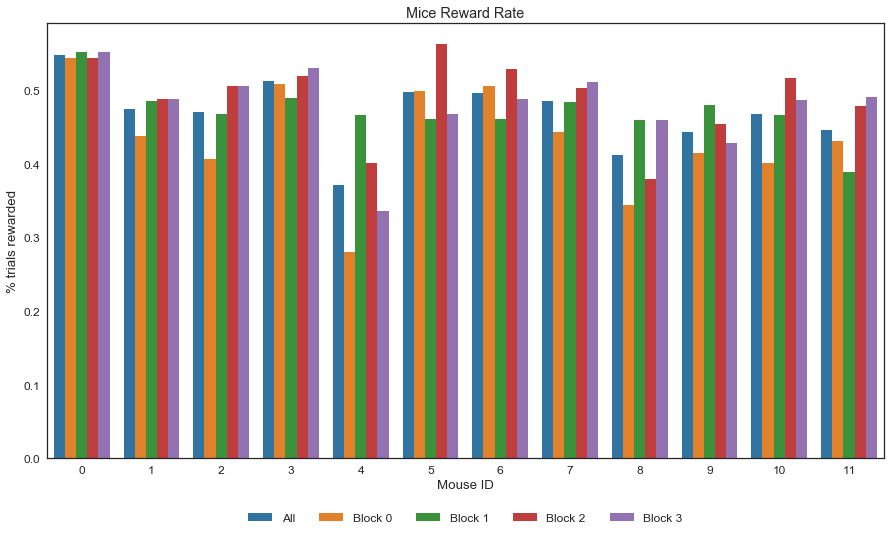

In [125]:
plt.figure(figsize = (15, 8))
sns.barplot(x = 'Mouse ID', y = 'Average', data = behavior, hue = 'Type')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('% trials rewarded')
plt.tight_layout
plt.title('Mice Reward Rate')

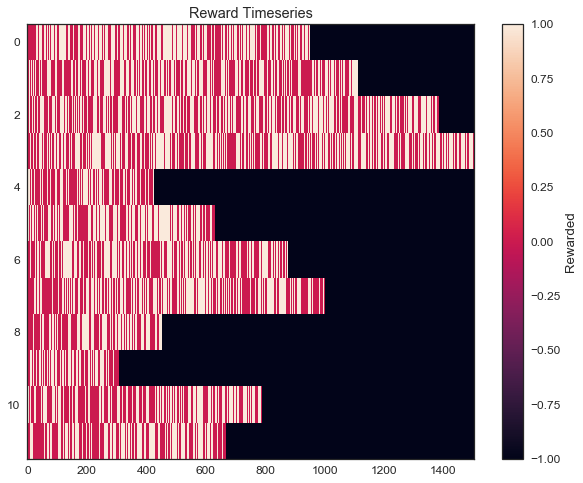

In [126]:
plt.figure(figsize = (10,8))

plt.imshow(r, aspect='auto')
plt.colorbar( label = 'Rewarded')
plt.title('Reward Timeseries')


## Part 2: 

Measure of Response Latency for Cons vs Ips

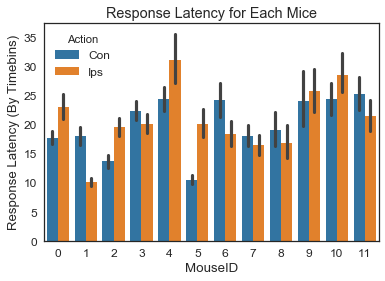

In [129]:
sns.barplot(x = 'MouseID', y = 'Delay', data = df_trials, hue = 'Action')
plt.ylabel('Response Latency (By Timebins)')
plt.title('Response Latency for Each Mice')

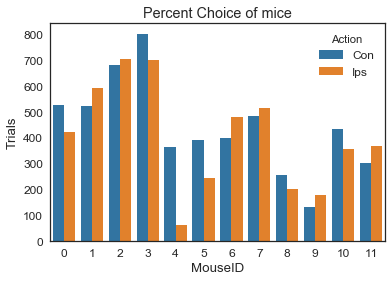

In [134]:
# sns.countplot(x="MouseID", data=df_trials, hue = 'Action')
ax = sns.barplot(x="MouseID", y="x", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")

plt.ylabel('Trials')
plt.title('Percent Choice of mice')

## Part 3: 

Time lock gcamp response

In [ ]:
def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

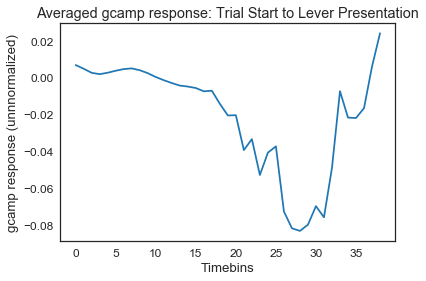

In [136]:
# for s in np.arange(NS): 

plt.plot(avgNestedLists(df_trials['g_pre_lever']))
plt.title('Averaged gcamp response: Trial Start to Lever Presentation')
plt.xlabel('Timebins')
plt.ylabel('gcamp response (unnnormalized)')

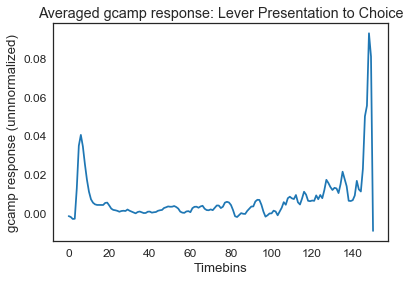

In [137]:
plt.plot(avgNestedLists(df_trials['g_pre_choice']))
plt.title('Averaged gcamp response: Lever Presentation to Choice')
plt.xlabel('Timebins')
plt.ylabel('gcamp response (unnnormalized)')

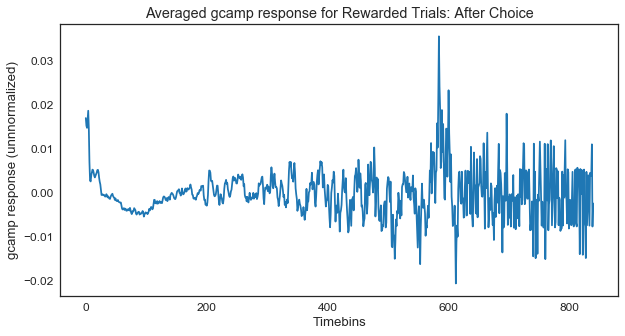

In [141]:
fig = plt.figure(figsize=(10,5))
plt.plot(avgNestedLists(df_trials[df_trials['Reward'] == 1]['g_post_choice']))
plt.title('Averaged gcamp response for Rewarded Trials: After Choice')
plt.xlabel('Timebins')
plt.ylabel('gcamp response (unnnormalized)')

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(avgNestedLists(df_trials[df_trials['Reward'] == 0]['g_post_choice']))
plt.title('Averaged gcamp response for unrewarded Trials: After Choice')
plt.xlabel('Timebins')
plt.ylabel('gcamp response (unnnormalized)')